In [8]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv, DataFrame, concat
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM

df = read_csv('ucsbdata.csv')
df.head()

,Index,R,US10YR,EPS,PER,OPEN,HIGH,LOW,CLOSE,BDIY,...,MYSTERYVAR3,TOM,HULBERTSENTIMENT,BUBBLE,CASH,DEBT,DIVIDEND,RETURN,STOCKS,WAR
0,1952-01-02,NaN,NaN,2.44,9.754098,23.80,23.80,23.80,23.80,NaN,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1952-01-03,NaN,NaN,2.44,9.786885,23.88,23.88,23.88,23.88,NaN,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1952-01-04,NaN,NaN,2.44,9.803279,23.92,23.92,23.92,23.92,NaN,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1952-01-07,NaN,NaN,2.44,9.799180,23.91,23.91,23.91,23.91,NaN,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1952-01-08,NaN,NaN,2.44,9.762295,23.82,23.82,23.82,23.82,NaN,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


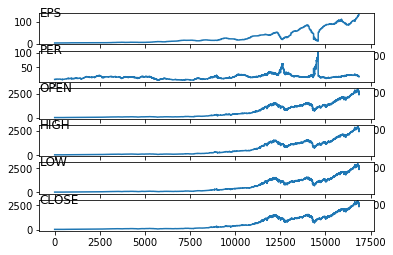

In [9]:
values = df.values
# specify columns to plot
groups = [3, 4, 5, 6, 7, 8]
i = 1
# plot each column
pyplot.figure()
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(df.columns[group], y=0.7, loc='left')
    i += 1
pyplot.show()

In [24]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 
# load dataset
data_frame = read_csv('ucsbdata.csv', header=0, index_col=0)
dataset= data_frame[['EPS', 'PER', 'OPEN', 'CLOSE', 'HIGH', 'LOW']]
values = dataset.values
dataset.index.name = 'Index'
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
#reframed.drop(reframed.columns[:, 10:68], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)   var1(t)  \
1   0.000766   0.032609   0.000374   0.000375   0.003649   0.000375  0.000766   
2   0.000766   0.032954   0.000402   0.000402   0.004160   0.000403  0.000766   
3   0.000766   0.033127   0.000415   0.000416   0.004379   0.000417  0.000766   
4   0.000766   0.033084   0.000412   0.000413   0.004306   0.000413  0.000766   
5   0.000766   0.032695   0.000381   0.000382   0.003795   0.000382  0.000766   

    var2(t)   var3(t)   var4(t)   var5(t)   var6(t)  
1  0.032954  0.000402  0.000402  0.004160  0.000403  
2  0.033127  0.000415  0.000416  0.004379  0.000417  
3  0.033084  0.000412  0.000413  0.004306  0.000413  
4  0.032695  0.000381  0.000382  0.003795  0.000382  
5  0.032350  0.000353  0.000354  0.003357  0.000355  


In [25]:
# split into train and test sets
values = reframed.values
n_train_hours = 13491
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(13491, 1, 11) (13491,) (3371, 1, 11) (3371,)


Train on 13491 samples, validate on 3371 samples
Epoch 1/50
 - 3s - loss: 0.0060 - val_loss: 0.0510
Epoch 2/50
 - 1s - loss: 0.0128 - val_loss: 0.0441
Epoch 3/50
 - 1s - loss: 0.0065 - val_loss: 0.0592
Epoch 4/50
 - 1s - loss: 0.0078 - val_loss: 0.0558
Epoch 5/50
 - 1s - loss: 0.0074 - val_loss: 0.0557
Epoch 6/50
 - 1s - loss: 0.0083 - val_loss: 0.0588
Epoch 7/50
 - 1s - loss: 0.0082 - val_loss: 0.0605
Epoch 8/50
 - 1s - loss: 0.0086 - val_loss: 0.0511
Epoch 9/50
 - 1s - loss: 0.0099 - val_loss: 0.0541
Epoch 10/50
 - 1s - loss: 0.0072 - val_loss: 0.0545
Epoch 11/50
 - 1s - loss: 0.0074 - val_loss: 0.0560
Epoch 12/50
 - 1s - loss: 0.0068 - val_loss: 0.0497
Epoch 13/50
 - 1s - loss: 0.0071 - val_loss: 0.0548
Epoch 14/50
 - 1s - loss: 0.0048 - val_loss: 0.0557
Epoch 15/50
 - 1s - loss: 0.0045 - val_loss: 0.0574
Epoch 16/50
 - 1s - loss: 0.0051 - val_loss: 0.0570
Epoch 17/50
 - 1s - loss: 0.0057 - val_loss: 0.0551
Epoch 18/50
 - 1s - loss: 0.0051 - val_loss: 0.0579
Epoch 19/50
 - 1s - loss

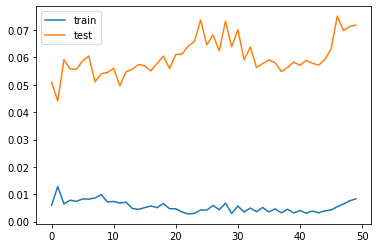

In [26]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [27]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

ValueError: operands could not be broadcast together with shapes (3371,11) (6,) (3371,11) 